# Project: Write a data science blog post

## Business Understanding

Salary or wages are a common talking point from business, personal finance, and economics.
But what's the bigger picture beyond mean and median?

1. How much can entry or junior level developers expect to be paid?
2. How much more do they earn with each year of experience?
3. At what point in a career do salaries or wages start to stagnate?

In [1]:
from collections import Counter

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# avoid burning my eyes @ night
plt.style.use('dark_background')

## Data Understanding and Exploration

The survey will ask participants to answer "Apples" to a question in order to check if they're paying attention to the questions. The published data set already purged rows that failed the check.

In [ ]:
FILE = 'data/survey_results_public.csv'
so_df = pd.read_csv(FILE)

print(so_df.keys())
so_df.describe()

# check for people who aren't paying attention
count_not_apple =  (so_df['Check'] != 'Apples').sum()
print(count_not_apple)
print(so_df.shape)
assert(count_not_apple == 0)
# print(so_df[:3])


In [3]:
# draw count plot of developers based on age

def visualize_devs(df, title, key='Age'):
    '''
    Draws count plot of developers based on attributes.

    inputs:
        df:    a DataFrame, the subset of the data set.
        title: string, title of the chart.
        key:   string, the attribute to count (age).
    outputs:
        no return values, will draw and save a graphic.
    '''
    plt.figure()
    plt.xticks(rotation=45)
    # from:
    # print(df[key].unique())
    order =  ['Under 18 years old', '18-24 years old',  \
              '25-34 years old','35-44 years old',\
              '45-54 years old', '55-64 years old',  \
              '65 years or older', 'Prefer not to say']
    sb.countplot(x=key, data=df, order=order)
    plt.title(title)
    filename= 'images/%s.png' % title.replace(" ", "-")
    plt.savefig(filename, bbox_inches='tight')


def get_lang_devs(df, lang):
    '''
    Returns a DataFrame, subset of the data set, of developers that have
    worked with a specified programming language.

    inputs:
        df:   a DataFrame, can be the entire published data set.
        lang: a string, the programming language.
    outputs:
        a DataFrame of developers that have worked with `lang` programming 
        language.
    '''
    col = 'LanguageHaveWorkedWith'
    # will not work for single character languages (C, R)
    # will mangle Java and JavaScript, Python and MicroPython
    return df[ df[col].str.contains(lang, na=False) ] 


def get_c_devs(df, lang='C'):
    '''
    Returns a DataFrame, subset of the data set, of developers that have
    worked with a specified programming language.
    Similar to get_lang_devs() but adapted for languages named by a single
    letter, or names like 'Java' which is contained in 'JavaScript'.

    inputs:
        df:   a DataFrame, can be the entire published data set.
        lang: a string, the programming language.
    outputs:
        a DataFrame of developers that have worked with `lang` programming 
        language.
    '''
    key = 'LanguageHaveWorkedWith'
    cdevs = []
    for index, dev in df.iterrows():
        try:
            # split string into list
            langs_used = dev[key].split(';')
            if lang in langs_used:
                cdevs.append(dev)
        except AttributeError:
#            print(dev[key])
            pass
    return pd.DataFrame(cdevs)

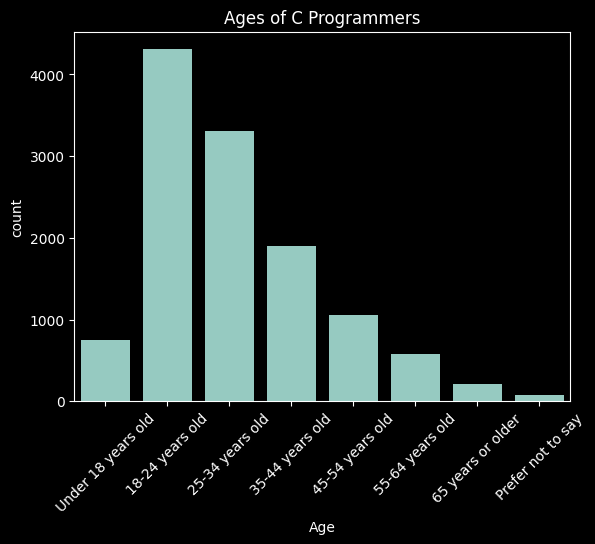

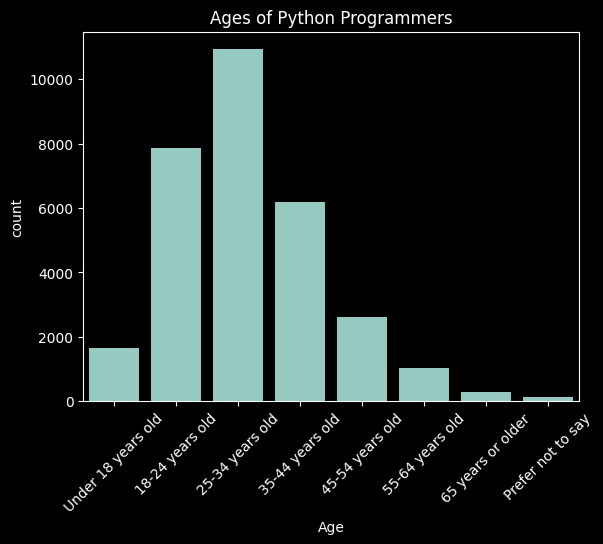

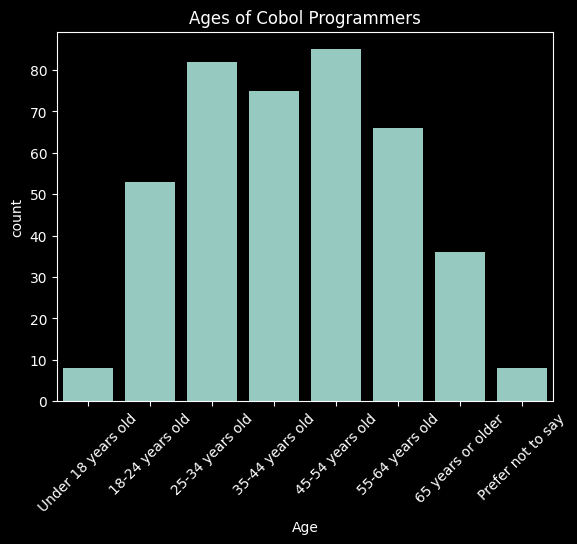

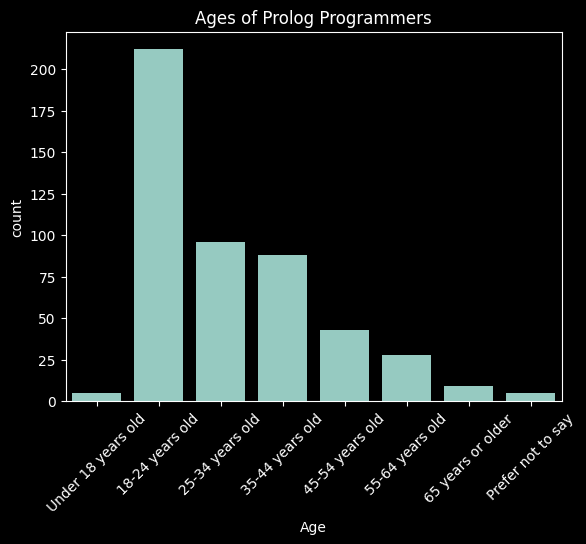

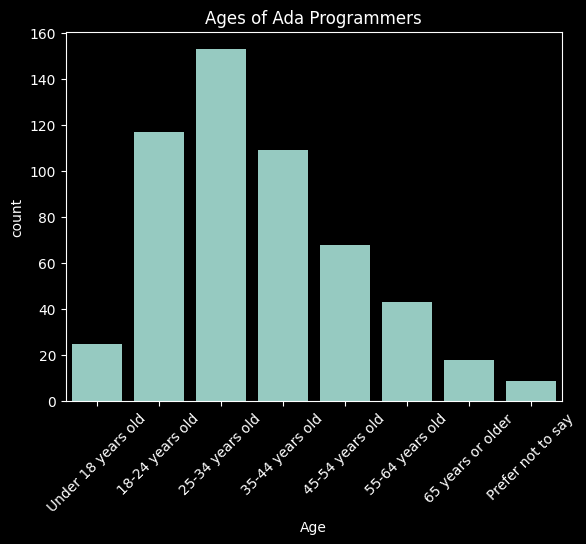

In [4]:
visualize_devs( get_c_devs(so_df) , 'Ages of C Programmers')
visualize_devs( get_c_devs(so_df, lang='Python') , 'Ages of Python Programmers')

for lang in ['Cobol', 'Prolog', 'Ada']:
    title = 'Ages of %s Programmers' % lang
    foo = get_lang_devs(so_df, lang)
    visualize_devs(foo, title)

## Preparing the Data

`__init__()` specifies which rows to omit and which to use, so the data for modeling doesn't look like a shotgun blast of rainbow colors.

### Handling Missing Values

Rows are dropped for developers who did not specify
* years of professional experience
* annual compensation

Very few developers did not specify years of experience. For this, a low number of rows were dropped which should not significantly alter results. However, many more developers did not specify their annual compensation. As the data is not available, such rows are dropped.

The distributions of years of experience are similar between the total number of developers and those included in the analysis.. See charts

* Python Developers Total vs Included
* C Developers Total vs Included


In [5]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import traceback
import numpy as np

# still haven't come up with a name
class Foo:
    def __init__(self, df, language, jobs=None, 
                 n_rich_outliers=0, n_poor_outliers=0, 
                 country='United States of America'):
        '''
        inputs:
            dataset:  A DataFrame, can be the full data set.
            language: string, the programming language 
                a developer has worked with.
            jobs:     list of strings, job positions 
            - typically domains where the language is dominant.
            n_rich_outliers: integer, removes samples from the 
                upper limit of the y-axis.
            n_poor_outliers: integer, removes samples from the 
                lower limit of the y-axis.
            country: string, specifies the country of origin.
        '''
        self.devs   = None
        self.canvas = None
        self.language = language
        self.country = country
        # focus on people who have given ...
        key_x  = 'YearsCodePro'
        key_y  = 'ConvertedCompYearly'
        self.key_x = key_x
        self.key_y = key_y

        qualifiers = {
            'MainBranch': 'I am a developer by profession',
       }
        if country:
            qualifiers['Country'] = country
        for k in qualifiers:
            df = df[df[k] == qualifiers[k] ] 

        # chatgpt tells me about filtering with multiple strings
        if jobs:
            df = df[df.isin(jobs).any(axis=1)]

        devs = None
        if len(language) == 1 or language in ['Python', 'Java']:
            devs = get_c_devs(df, lang=language)
        else:
            devs = get_lang_devs(df, language)

        self.df_no_x = devs[devs[key_x].isnull()]
        self.df_no_y = devs[devs[key_y].isnull()]
        devs  = devs.dropna(subset=[key_x, key_y])

        replacement_dict = {
            'Less than 1 year': '0.5',
            'More than 50 years': '51',
        }

        # https://stackoverflow.com/questions/47443134/update-column-in-pandas-dataframe-without-warning
        pd.options.mode.chained_assignment = None  # default='warn'
    
        new_column = devs[key_x].replace(replacement_dict)
        devs[key_x] = pd.to_numeric(new_column, errors='raise')

        new_column = self.df_no_y[key_x].replace(replacement_dict)
        self.df_no_y[key_x] = pd.to_numeric(new_column, errors='raise')
        pd.options.mode.chained_assignment = 'warn'  # default='warn'
        # print( devs[key_x].unique() )
        
        indices  = devs[key_y].nlargest(n_rich_outliers).index
        devs = devs.drop(indices)
        indices  = devs[key_y].nsmallest(n_poor_outliers).index
        self.devs = devs.drop(indices)
        del devs, new_column
    
    def visualize(self,  hue='Country', 
                  palette=sb.color_palette() ):
        '''
        Draw scatter plot of samples included in self.devs.

        inputs:
            hue:     string, colorize dots by a given key.
            palette: list of strings (color codes)
                     or string (matplotlib predefined palettes),
                     specifies the colors to use when coloring dots.
        '''
        self.canvas = plt.figure()
        key_x = self.key_x
        key_y = self.key_y

        sb.scatterplot(data=self.devs, x=key_x, y=key_y, hue=hue, palette=palette)
        plt.legend(loc='lower center', bbox_to_anchor=(1.5,0)) 
        title = 'Annual Compensation of %s Programmers Over Years of Experience' % self.language\
                + '\nsample size=%i' %  len (self.devs)\
                + '\ncountry=%s' % self.country
        plt.title(title)

    def run_regression(self, x_transform=None, change_base=1.07, 
                       x_shift=0, y_shift=0,
                       random=333, risky=0,
                       color='red', name='Regression Line' ):
        '''
        Run linear regresssion and draws a straight line.

        inputs:
            x_transform: function, function to tune the independent variable.
            change_base: float or integer, specifies base 
                for logarithmic function, not used if x_transform is None.
            x_shift: integer, for tuning, shifts the position 
                of the line on the x-axis.
            y_shift: integer, for tuning, shifts the position 
                of the line on the y-axis.
            random:  integer, random seed for train_test_split; 
                change to test generalization.
            risky    integer ranging from 0 to 2,
                    0 = does nothing (default),
                    1 = sorts the independent variable,
                    2 = sorts the dependent variable,
               performs unrecommended operation to sort data,
               risking the model training on the order of values.
               May draw nice lines that generalize across random states.
           color: string, color of the regression line.
           name:  string, label of regression line on the legend.
        '''
        df = self.devs # .sort_values(by = self.key2)
        X = df[[self.key_x]]
        y = df[[self.key_y]]

        # not recommended
        # carries risk of model training on sorted order
        # however it appears to be generalizing well
        # across random state and shuffle (=True, default)
        style = '-'
        if risky > 0:
            X = X.sort_values(by=self.key_x)
            style = '--'
        if risky > 1:
            y = y.sort_values(by=self.key_y)
        if x_transform is not None:
            X = x_transform (X, a=change_base ) 

        X = X + x_shift
        y = y + y_shift
    
        X_train, X_test, y_train, y_test = train_test_split(
                                                X, y, 
                                                test_size=0.2, 
                                                random_state=random)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        m = model.coef_[0][0]
        b = model.intercept_[0]
        label = '%s regression line for %s' % (color, self.language)
        show_model_stats(m, b, y_test, y_pred, label)

        plt.figure(self.canvas)
        plt.plot(X_test, y_pred, color=color, label=name, linestyle=style)
        plt.axhline(y=b, color='purple', linestyle='--', 
                    label='b=%0.2f' % b, zorder=-1 )
        plt.legend(loc='lower center', bbox_to_anchor=(1.5,0)) 
        del y_pred, model, X, y

    def run_log_regression(self, transform=np.log, color='pink', nodraw=True):
        '''
        Runs logarithmic regression and draws a line that contours 
        at the point of diminishing returns.

        Logarithmic regression provides a better fit for the data;
        however, it is not part of the course.

        Can illustrate an interesting relationship between the
        "default" linear model and a tuned linear model.

        inputs:
            color:   color of the regression line.
            nodraw:  whether or not to draw the line.
        '''
        df = self.devs
        X = df[[self.key_x]] #.sort_values(by=self.key_x)
        y = df[[self.key_y]] #.sort_values(by=self.key_y)

        X_train, X_test, y_train, y_test = train_test_split(
                                                X, y, 
                                                test_size=0.2, 
                                                random_state=777)
    
        X_train_log = transform(X_train)
        X_test_log = transform(X_test)
    
 #       X_train_log = X_train_log.sort_values(by=self.key_x)
 #       y_train = y_train.sort_values(by=self.key_y)
        X_test_log = X_test_log.sort_values(by=self.key_x)
        X_test = X_test.sort_values(by=self.key_x)
        y_test = y_test.sort_values(by=self.key_y)
        
        model = LinearRegression()
        model.fit(X_train_log, y_train)
        y_pred = model.predict(X_test_log)
        y_pred.sort()

        m = model.coef_[0][0]
        b = model.intercept_[0]
        label = '%s log regression line for %s' % (color, self.language)
        show_model_stats(m, b, y_test, y_pred, label)

        if nodraw:
            return
        plt.plot(X_test, y_pred, color=color, label="Log regression")
        plt.axhline(y=b, color='purple', linestyle='--', 
                    label='b=%0.2f' % b, zorder=-1 )
        plt.plot(X_test, dy_dx_log(m, X_test), color='cyan', label='1st derivative')
        plt.legend(loc='lower center', bbox_to_anchor=(1.5,0)) 

    def export_image(self, base_filename = 'images/programmers-%s-%s.png'):
        '''
        Saves canvas to file.

        inputs:
            base_filename: string with two format codes (two strings),
                this string will be interpolated by...
                1. the programming language
                2. the country of origin.
        '''
        plt.figure(self.canvas)
        filename = base_filename % (self.language, self.country)
        plt.savefig(filename.replace(' ', '-'), bbox_inches='tight')

    def probe_excluded_rows(self):
        '''
        Display information about developers excluded from analysis.
        '''
        nan_x_count = self.df_no_x.shape[0]
        nan_y_count = self.df_no_y.shape[0]
        print(nan_x_count, 'did not specify', self.key_x)
        print(nan_y_count, 'did not specify', self.key_y)
        print('total developers:', self.devs.shape[0] 
              + nan_x_count + nan_y_count)
        title = '%s Developers Total vs Included' % self.language
        total_devs = pd.concat([self.devs, self.df_no_y])
    
        plt.figure()
        plt.title(title)
        plt.xticks(rotation=45)
        key   = self.key_x

        bins = [0, 10, 20, 30, 40, 50]
        labels = ['0-10', '11-20', '21-30', '31-40', '41-50']
        total_binned = pd.cut(total_devs[key], bins=bins, labels=labels).to_frame()
        devs_binned  = pd.cut(self.devs[key], bins=bins, labels=labels).to_frame()

        sb.countplot(x=key, data=total_binned, label='total')
        sb.countplot(x=key, data=devs_binned,
                     color='red', label='included in analysis')
        plt.legend()
        plt.savefig('images/%s-total-vs-included.png' % self.language)
        
    
def show_model_stats(coef, intercept, y_test, y_pred, label):
    '''
    Displays model performance.

    inputs:
        coef:      the coefficient of the model.
        intercept: the y-intercept of the model.
        y_test:    true values to compare against model predictions.
        y_pred:    prediction values from the model.
    
        label:     string, to help identify which line (e.g color).
    '''
    print('+----------------------+')
    print(label)
    print('coefficient = %0.2f' % coef)
    print('intercept = %0.2f' % intercept)
    rmse = root_mean_squared_error(y_test, y_pred)
    print('rmse = %0.2f' % rmse)
    r2   = r2_score(y_test, y_pred)
    print('r2 score = %0.2f' % r2)
    print('sample predictions:')
    print(y_pred[3:6])
    print('+----------------------+')

def dy_dx_log(coef, x):
    '''
    Function for the derivative of a log function.
    dy/dx = a/x

    inputs:
        coef: coefficient
        x: the independent variable
    '''
    return coef/x

# the higher a is, the steeper the line gets
def log_base_a(x, a=1.07):
    '''
    Performs logarithmic transformation of value 'x' with base 'a'.

    inputs:
        x: numeric, the variable to be transformed.
        a: numeric, the new base.
    '''
    return np.log10(x)/np.log(a)

## Data Modeling

Generate models for American python programmers working as data scientists/analysts/engineers.

+----------------------+
pink regression line for Python
coefficient = 24693.77
intercept = 32684.83
rmse = 11177.22
r2 score = 0.96
sample predictions:
[[147145.55871884]
 [178849.96832633]
 [ 32684.82967671]]
+----------------------+
+----------------------+
red log regression line for Python
coefficient = 28995.42
intercept = 91543.33
rmse = 30814.08
r2 score = 0.65
sample predictions:
[[123398.04864925]
 [123398.04864925]
 [131739.51024811]]
+----------------------+
1 did not specify YearsCodePro
165 did not specify ConvertedCompYearly
total developers: 374


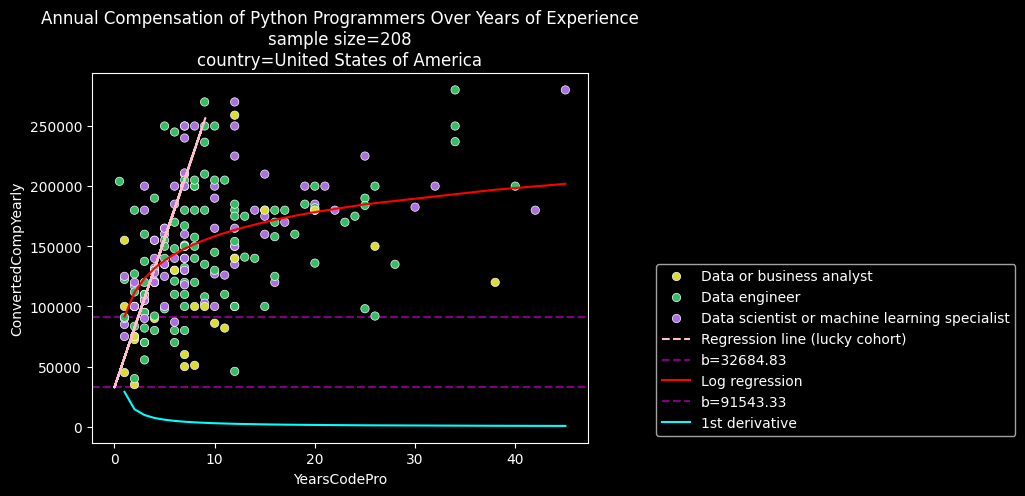

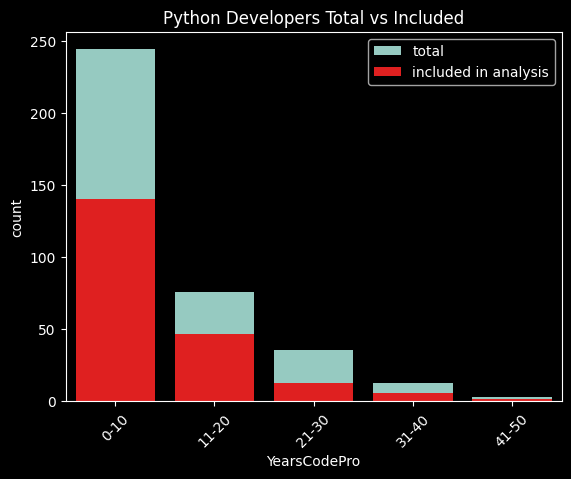

In [6]:

# expected python jobs
pyjobs = ['Data scientist or machine learning specialist',
          'Data or business analyst',
          'Data engineer',
#        "DevOps specialist",
#        "Developer, QA or test"
]

python = Foo(so_df, 'Python', jobs=pyjobs, n_rich_outliers=12, n_poor_outliers=2)
python.visualize(hue='DevType', palette=['#dbdb32', '#34bf65', '#ac70e0'])
#python.run_regression(name = 'Default regression line')
#python.run_regression( x_transform=log_base_a, change_base=1.20, 
#                       x_shift=0, y_shift=-1.5e4, random=888,
#                       color='cyan', name='Tuned regression line')

python.run_regression(x_transform=log_base_a, change_base=1.20, risky=2, random=555, 
                      color='pink', name='Regression line (lucky cohort)')
python.run_log_regression(nodraw=False, color='red')
python.export_image()
python.probe_excluded_rows()

## Evaluation (Python)

### Logarithmic Model

The r2 score of the logarithmic model is 0.65, which is pretty good. There is an root mean squared error of 30,814.08 dollars, so the model is off by this much for a given point in a career.

Logarithms can make the coefficient a little tricky to interpret. So the quotient rule is cited below.

    log(x_2) - log(x_1) = log(x_2/x_1)

Therefore, how much more money does a data scientist earn working from the 1st year of their career into the 2nd year?

Given a coefficient of 28995.42,

* x_2 = 2
* x_1 = 1
* 28995.42 * log(2/1) = 8728.5

The total income ($) at 2 years of experience = 91,543.33 + 8,728.5 = 100,271 .

From year 1 to year 2, a data scientist can expect to earn $8,728.5 more than the previous. However a logarithmic function models diminishing returns. So the same increase is projected going from year 2 to year 4 as `log(2/1) == log(4/2)`.

### Lucky Cohort? (Pink line)

*This line is drawn for visualization purposes.*

The scatter plot of Python developers appears like splash of water that bifurcates. Data scientists, analysts, and engineers are employed in a wide range of fields such as advertising, finance, bio/medical, and so forth. So the split can be interpreted as a fork in their career paths.

Among data scientists and engineers but not as much analysts, it can be interpreted that there is a cohort that experiences a linear rise in incomes of 24,693.77 each year. However, there are no points continuing this trend from professionals with greater than 10 years of experience, so the lucky cohort could be employed in a recent application of machine learning.
  

## Data Modeling and Evaluation (for C)

Generate models for American C programmers working as embedded systems developers, hardware engineers, or graphics/game programmers.

+----------------------+
red log regression line for C
coefficient = 20734.28
intercept = 83648.77
rmse = 17490.15
r2 score = 0.75
sample predictions:
[[ 98020.67915334]
 [106427.70806024]
 [106427.70806024]]
+----------------------+
2 did not specify YearsCodePro
175 did not specify ConvertedCompYearly
total developers: 293


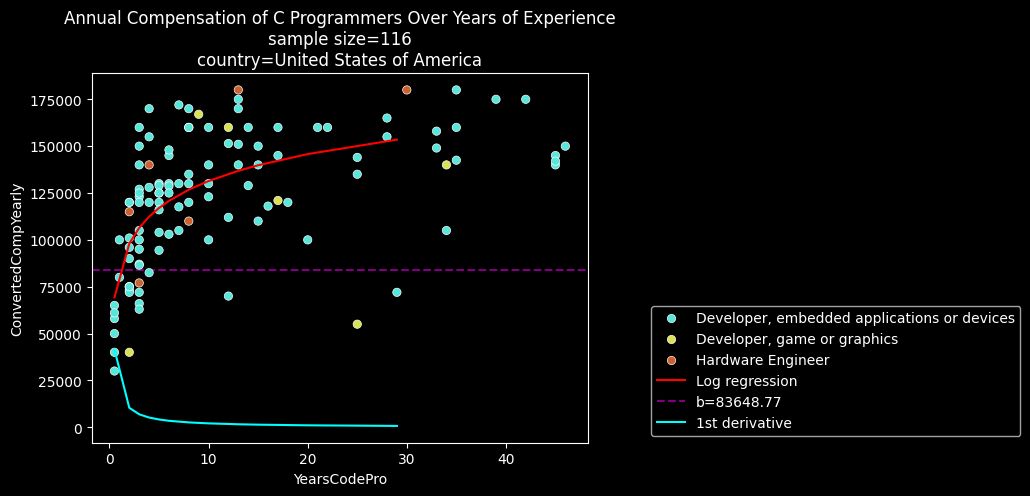

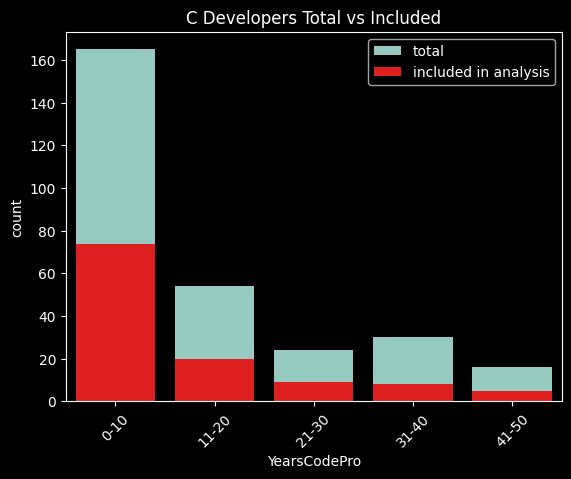

In [7]:
# expected C jobs
cjobs = [
    'Developer, embedded applications or devices', 
    'Developer, game or graphics',
    'Hardware Engineer',
 #        "Project manager", 
 #        "Product manager"
]
c = Foo(so_df, 'C', jobs=cjobs, n_rich_outliers=30, n_poor_outliers=2)
c.visualize(hue='DevType', palette=['#57e6da','#d9e352','#cc622d'] ) #
#c.run_regression()
#c.run_regression(x_transform=log_base_a, change_base=1.3, 
#                 x_shift=2, y_shift=-5000, color='magenta', random=555)
c.run_log_regression(nodraw=False, color='red')
c.export_image()
c.probe_excluded_rows()

## Evaluation for C

An r2 score of 0.75 means the logarithmic model is doing a better job than it did for Python developers. With a root mean squared error of 17,490.15, the earnings of a C developer is more predictable than Python developers. (The model is off by 17,490.15 when describing the incomes of C developers.)

A larger proportion of C developers are 18-24 years old compared to Python, so less of them on average will have careers as advanced. Here, it looks like they don't make as much money. But the coefficient still has the $20,000 handle.

* x_2, second year in career
* x_1, first year in career
* 20734.28 * log(2/1) = 6241

A C developer going from the first year in their careers to the second will have earned 6,241 more dollars. Because a logarithmic function models diminishing returns, they can expect the same raise going from year 2 to year 4 as `log(2/1) == log(4/2)`.




## (More) Data Understanding and Exploration

Below cells generate extra or unused graphs.
I put this here because I want to restart the kernel and re-run cells until this point.

In [ ]:

jsjobs = ["Developer, full-stack",
          "Developer, front-end",
          "Developer, mobile"
]

js = Foo(so_df, "JavaScript", jobs=jsjobs, n_rich_outliers=6, country="Ukraine")
js.visualize(hue="DevType")
js.export_image()

In [ ]:
# get popularity of different programming languages

#keys re: languages are:
#LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,LanguageDesired

# draw as strip chart
# https://seaborn.pydata.org/generated/seaborn.stripplot.html#seaborn.stripplot

def get_langs(dataset, key="LanguageHaveWorkedWith"):
    lang_count = Counter()
    assert(key in dataset.keys())
    for response in dataset[key]:
        if type(response) == str:
            lang_count.update(response.split(';'))
    langs_by_popularity = dict(
        sorted(lang_count.items(), key=lambda item: item[1], reverse=True)
    )
    return langs_by_popularity

def visualize_langs(langs, langs2, label1 = "condition1", label2 = "condition2", saveto=None):
    DOT_COLOR1 = "lightblue"
    DOT_COLOR2 = "red"
    BG_COLOR   = "black" 
    df    = pd.DataFrame(langs.items(), columns=['Languages', 'Count'])
    df2   = pd.DataFrame(langs2.items(), columns=['Languages', 'Count'])
    
    plt.figure(figsize=(10,15)) 
    
    sb.stripplot(x='Count', y='Languages', data=df, \
                 size=5, color=DOT_COLOR1, label="have worked with", jitter=True)
    sb.stripplot(x='Count', y='Languages', data=df2, \
                 size=5, color=DOT_COLOR2, label="want to work with", jitter=True)
    
    # chatgpt draws my legend
    # Create custom legend handles to avoid duplicates
    # color = 'w' means do not draw line bissecting point
    blue_patch = plt.Line2D(
        [0], [0], marker='o', color=BG_COLOR, \
        label=label1, markerfacecolor=DOT_COLOR1, markersize=10)
    red_patch = plt.Line2D(
        [0], [0], marker='o', color=BG_COLOR, \
        label=label2, markerfacecolor=DOT_COLOR2, markersize=10)
    
    # Show the legend with custom handles
    plt.legend(handles=[blue_patch, red_patch], loc="center right")
    
    plt.grid(axis='x', linestyle='--', alpha=0.75) 
    plt.title("%s vs %s" % (label1, label2))
    if saveto is not None:
        plt.savefig(saveto, bbox_inches='tight')
    del df, df2

l1 = get_langs( so_df )
l2 = get_langs( so_df, "LanguageWantToWorkWith" )
visualize_langs(l1,l2, 
                label1="have worked with", label2="want to work with",
                saveto="images/used-vs-want2use.png")

l3 = get_langs( so_df, "LanguageAdmired")
l4 = get_langs( so_df, "LanguageWantToWorkWith")
visualize_langs(l3, l4, 
                label1="admired", label2="want to work with",
               saveto="images/admired-vs-want2use.png")
    

In [ ]:
# draw horizontal bar plot
# https://seaborn.pydata.org/examples/part_whole_bars.html

# investigate extrinsic vs intrinsic motivation
def get_difference(dict1, dict2, proportion=False):
    keys = dict1.keys()
    result = dict()
    for key in keys:
        if proportion:
            result[key] = round((dict1[key] - dict2[key])/dict2[key],2)
        else:
            result[key] = dict1[key] - dict2[key]
    return result

def visualize_diff(diff_dict, color="lightblue", saveto=None):
    diff_sorted = dict(
        sorted(diff_dict.items(), key=lambda item: item[1], reverse=True)
    )
    KEY = "Value"
    df    = pd.DataFrame(diff_sorted.items(), columns=['Languages', 'Value'])
    plt.figure(figsize=(15,20)) 
    sb.barplot(x=KEY, y='Languages', data=df, color=color)
    DELTA =  '\u0394'
    for index, value in enumerate(df[KEY]):
    # chatgpt annotates my chart
    # Position the text at the base of the bar
        if value >= 0:
            # Adjust the x position for positive values
            plt.text(value, index, DELTA+str(value), va='center', ha="left")  
        else:
             # Adjust the x position for negative values
            plt.text(value, index,  DELTA+str(value), va='center',  ha='right') 
    lowest = 0
    offset = 0
    positive_values = df[df[KEY] > 0][KEY]
    if not positive_values.empty:
        lowest = positive_values.min()
        offset = list(positive_values).count(lowest) 
    if len(positive_values) < len(df):
        # don't draw the line if every value is greater than 0_
        plt.axhline(y=df[KEY].tolist().index(lowest) + (offset-0.5), 
                    color='red', linestyle='--', zorder=-1)
    if saveto is not None:
        plt.savefig(saveto, bbox_inches='tight')
    
motiv_diff = get_difference(l2, l1, proportion=True)
# print(motiv_diff)
visualize_diff(motiv_diff, saveto="images/delta.png")
motiv_diff = get_difference(l2, l1)
visualize_diff(motiv_diff, saveto="images/delta-b.png")

# no clear description of what "admired" is
# in the schema
# but generally people want to use the languages
# they admire

# determine level of hype
# hype = get_difference(l4, l3)
# print(hype)
# visualize_diff(hype, color="red")

In [ ]:
# do people fall out of love with langs
# the more they are used professionally?

def visualize_favor(df, key_x, key_y, MAGIC_X=0, MAGIC_Y=0, title=str(), saveto=None):
    plt.figure()
    OFFSET = 1 # push text away from point slightly
    for i in range(merged.shape[0]):
        # label points that aren't un a cluster
        if merged[key_x][i] > MAGIC_X or merged[key_y][i] > MAGIC_Y:
            plt.text(merged[key_x].iloc[i]+OFFSET, 
                     merged[key_y].iloc[i]+OFFSET, 
                     merged["Language"].iloc[i], 
                     ha="left",
                     size='medium')

    sb.scatterplot(data=merged, x=key_x, y=key_y, hue="Language")
    plt.legend(loc='lower left', bbox_to_anchor=(0, -1.25), ncol=3) 
    plt.title(title)
    if saveto is not None:
        plt.savefig(saveto, bbox_inches='tight')
    pass
key_x  = "Users"
key_y  = "Potential '\u0394'Users"
df1    = pd.DataFrame(l1.items(), columns=['Language', key_x])
df2    = pd.DataFrame(motiv_diff.items(), columns=['Language', key_y])
# chatgpt tells me how to combine df
merged = pd.merge(df1, df2[["Language", key_y]], on='Language', how='left')
visualize_favor(merged, key_x, key_y, 
                MAGIC_X=5000, MAGIC_Y=2000, 
                saveto="images/favor.png")
del df1, df2, merged

In [ ]:
# see how much money are people making

def get_mean_by_category(df, category, key="ConvertedCompYearly"):
    unique = df[category].unique()
    result = dict()
    for u in unique:
        mean = df[df[category] == u][key].mean()
        result[u] = mean
    return result

def show_me_the_money(df, saveto=None):
    key_x = "ConvertedCompYearly"
    key_y = "DevType"
    
    means   = get_mean_by_category(df, key_y) 
    mean_df = pd.DataFrame(means.items(), columns=[key_y, key_x])

    plt.figure(figsize=(14,18)) 
    plt.axvline(x=1e5, color='red', linestyle='--', label="x = $100,000")
    plt.axvline(x=1e6, color='lightgreen', linestyle='--', label="x = millionaire")
    sb.barplot(x=key_x, y=key_y, data=mean_df.sort_values(by=key_x), \
               color='lavender', alpha=0.7, label="average compensation")
    sb.stripplot(x=key_x, y=key_y, data=df, \
                 size=3, jitter=True)
    if saveto is not None:
        plt.savefig(saveto, bbox_inches='tight')
    
# print survey ans
#employment_status = Counter(so_df["MainBranch"])
#print(employment_status)

#employment_type = Counter(so_df["DevType"])
#print(employment_type)

key = "ConvertedCompYearly"
#    answers = so_df[:-1][key].count()
#    print(answers, "people answered re: ", key)
df_no_na = so_df.dropna(subset=[key])
indices  = df_no_na[key].nlargest(15).index

show_me_the_money( df_no_na.drop(indices), saveto="images/compensation-by-profession.png" )
# could also ask myself what portion of developers 
# earn less than the mean compensation
# (what titles have high standard deviations in earnings)

In [ ]:

# key   = "DevType"
# prof  = "Developer, full-stack"

key   = "MainBranch"
prof = "I am a developer by profession"
col   = "ConvertedCompYearly"

devs =  df_no_na[df_no_na[key] ==  prof ] 
pd.set_option('display.float_format', '{:.2f}'.format)
devs.describe()[col]

# who the hell is making $1/yr 
# devs[devs[col] == 1.0]

# who are the millionaires
# devs[devs[col] > 1e6]

# who make more than the mean
# devs[devs[col] > 76230.84]

# who make more than the median
# devs[devs[col] > 63316.00]

# the ancient ones
so_df[so_df["YearsCodePro"] == 'More than 50 years']
# should drop the 18-24 year old who is either bullshitting or recalls a past life
# 55-64 years old
# 65 years or older